In [39]:
import json
import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from tqdm import tqdm
import time

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

%pprint
%matplotlib inline

Pretty printing has been turned ON


In [40]:
import requests_cache

requests_cache.install_cache()

In [41]:
#TODO: Replace ' ' with " "

# Artist & Song Dataframe

Load lyrics dataframe 

In [42]:
lyrics_df = pd.read_csv("../data/lyrics-data.csv")
artists_df = pd.read_csv('../data/artists-data.csv')

Show general information for the dataframes

In [43]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379931 entries, 0 to 379930
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ALink     379930 non-null  object
 1   SName     379928 non-null  object
 2   SLink     379930 non-null  object
 3   Lyric     379854 non-null  object
 4   language  365296 non-null  object
dtypes: object(5)
memory usage: 14.5+ MB


In [44]:
artists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4168 entries, 0 to 4167
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Artist      4167 non-null   object 
 1   Genres      4163 non-null   object 
 2   Songs       4167 non-null   float64
 3   Popularity  4166 non-null   float64
 4   Link        4167 non-null   object 
dtypes: float64(2), object(3)
memory usage: 162.9+ KB


Create dataframe with song name and artist name (only English songs)

In [69]:
artists_songs_dataframe = pd.merge(artists_df, lyrics_df, how="inner", left_on="Link", right_on="ALink")
artists_songs_dataframe = artists_songs_dataframe[artists_songs_dataframe["language"] == "en"][["Artist", "SName"]]

In [46]:
artists_songs_dataframe.head()

,Artist,SName
69,Ivete Sangalo,Careless Whisper
86,Ivete Sangalo,Could You Be Loved / Citação Musical do Rap: S...
88,Ivete Sangalo,Cruisin' (Part. Saulo)
111,Ivete Sangalo,Easy
140,Ivete Sangalo,For Your Babies (The Voice cover)


In [47]:
artists_songs_dataframe[(artists_songs_dataframe["Artist"] == "Eminem") & (artists_songs_dataframe["SName"] == "Mockingbird")]

,Artist,SName
170568,Eminem,Mockingbird


In [48]:
artists_songs_dataframe[artists_songs_dataframe["Artist"] == "Eminem"]

,Artist,SName
170557,Eminem,Lose Yourself
170558,Eminem,The Real Slim Shady
170559,Eminem,Rap God
170560,Eminem,Without Me
170561,Eminem,Stan (feat. Dido)
...,...,...
171038,Eminem,"You Gon' Learn (Feat. Royce da 5'9"" & White Gold)"
171039,Eminem,You Still Love Me
171040,Eminem,You're Never Over
171041,Eminem,Zelda Rap (Remix)


In [49]:
# Number of English songs
print(f"Number of English songs: {artists_songs_dataframe['SName'].count()}")

# Number of all artists with English songs
print(f"Number of all artists with English songs: {artists_songs_dataframe['Artist'].nunique()}")

Number of English songs: 191385
Number of all artists with English songs: 2488


In [50]:
# TODO: Add normalization of the song names (remove (feat. ...))
# TODO: Alternatively, load all songs from the artist and find out the mib to definitely find the song

# Lastfm DB (Baseline Github Project)

In [51]:
# TODO: Analyze artists and song names in lastfm dataset
# TODO: Normalize song names? Transform to lowercase? Remove "feat", ...
# TODO: Check similarly as in baseline project for similar mood keywords (e.g. with stemming, ...)

In [52]:
# TODO: Try their implementation first (make it running) --> When it works, test here

# TODO: Copy and paste their code and database
# TODO: Replace their db with updated db (add code for downloading theses songs)

The following code snippets are based on code from: https://github.com/workmanjack/lyric-mood-classification, which included and advanced the code from following sources (http://millionsongdataset.com/sites/default/files/lastfm/demo_tags_db.py, https://www.tomordonez.com/get-schema-sqlite-python/)

In [53]:
# Code from label_lyrics.py

def sanitize(tag):
    """
    sanitize a tag so it can be included or queried in the db
    """
    tag = tag.replace("'","''")
    return tag

def query(db_conn, sql):
    """
    Execute the provided sql query on the provided db.

    WARNING: can cause memory issues
    """
    response = db_conn.execute(sql)
    data = response.fetchall()
    return data

In [54]:
# from Table 2 on pg 413 of http://www.ismir2009.ismir.net/proceedings/PS3-4.pdf
MOOD_CATEGORIES = {
    'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill out'],
    'sad': ['sadness', 'unhappy', 'melancholic', 'melancholy'],
    'happy': ['happy', 'happiness', 'happy songs', 'happy music'],
    'romantic': ['romantic', 'romantic music'],
    'upbeat': ['upbeat', 'gleeful', 'high spirits', 'zest', 'enthusiastic'],
    'depressed': ['depressed', 'blue', 'dark', 'depressive', 'dreary'],
    'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
    'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'],
    'dreamy': ['dreamy'],
    'cheerful': ['cheerful', 'cheer up', 'festive', 'jolly', 'jovial', 'merry'],
    'brooding': ['brooding', 'contemplative', 'meditative', 'reflective'],
    'aggression': ['aggression', 'aggressive'],
    'confident': ['confident', 'encouraging', 'encouragement', 'optimism'],
    'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'],
    'earnest': ['earnest', 'heartfelt'],
    'desire': ['desire', 'hope', 'hopeful', 'mood: hopeful'],
    'pessimism': ['pessimism', 'cynical', 'pessimistic', 'weltschmerz'],
    'excitement': ['excitement', 'exciting', 'exhilarating', 'thrill', 'ardor']
}

In [55]:
# TODO: Change this after downloading the updated lastfm DB
import sqlite3

lastfm_path = 'data/lastfm_tags.db'
dbpath = os.path.abspath(lastfm_path)
print(dbpath)
conn = sqlite3.connect(dbpath)
conn

/home/phansen/Documents/Project/ta_lyrics_sentiment_classification/data_exploration/lastfm_labels/data/lastfm_tags.db


### Example Queries to explore the lastfm DB

In [56]:
print('************** DEMO 4 **************')
tag = 'Acid Smurfs'
print('We get all tracks for the tag: {0}'.format(tag))
sql = f"SELECT tids.tid FROM tags, tids, tid_tag WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND tags.tag='{sanitize(tag)}'"
res = conn.execute(sql)
data = res.fetchall()

pprint(data)

************** DEMO 4 **************
We get all tracks for the tag: Acid Smurfs
[('TRDATLJ128F92FC75F',),
 ('TRVTZIF128F42725C1',),
 ('TREPQOO128F9328886',),
 ('TROXKKP128F427886F',)]


In [57]:
print('************** DEMO 4 **************')
tag = 'Acid Smurfs'
print('We get all tracks for the tag: {0}'.format(tag))
sql = "SELECT tids.tid FROM tags, tids, tid_tag WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND tags.tag='{0}'".format(sanitize(tag))
res = conn.execute(sql)
data = res.fetchall()

pprint(data)

************** DEMO 4 **************
We get all tracks for the tag: Acid Smurfs
[('TRDATLJ128F92FC75F',),
 ('TRVTZIF128F42725C1',),
 ('TREPQOO128F9328886',),
 ('TROXKKP128F427886F',)]


In [58]:
print('************** DEMO 5 **************')
print("We get all tags and the number of tracks they're applied to")
sql = "SELECT tags.tag, COUNT(tid_tag.tid) FROM tid_tag, tags WHERE tid_tag.tag=tags.ROWID GROUP BY tags.tag"

### WARNING - this one takes a minute... uncomment these lines to execute
#res = conn.execute(sql)
#data = res.fetchall()
#data = sorted(data, key=lambda x: x[1], reverse=True)
#print('after sorting...')
#for k in range(10):
#    print(data[k])
#print('...')

************** DEMO 5 **************
We get all tags and the number of tracks they're applied to


### Last.fm DB Schema Exploration

In order to use the provided db effectively, we need to know its schema. Here we use sql commands to expose its table structure (credit: https://www.tomordonez.com/get-schema-sqlite-python.html).

It turns out that the schema is incredibly simple.


In [59]:
cur = conn.cursor()

tables = list()
for row in cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall():
    tables.append(row[0])

print('Tables: {0}\n'.format(tables))

for table in tables:
    
    cols = list()
    for row in cur.execute("pragma table_info('{0}')".format(table)).fetchall():
        cols.append(row[1])

    row_count = cur.execute("SELECT Count(*) FROM {0}".format(table)).fetchall()[0][0]
        
    print('Table "{0}"'.format(table))
    print('\tcolumns: {0}'.format(cols))
    print('\trows: {0}'.format(row_count))
    
    #print(cur.execute("SELECT * FROM {0} LIMIT 5".format(table)).fetchall())
    
cur.close()

Tables: ['tags', 'tids', 'tid_tag']

Table "tags"
	columns: ['tag']
	rows: 522366
Table "tids"
	columns: ['tid']
	rows: 505216
Table "tid_tag"
	columns: ['tid', 'tag', 'val']
	rows: 8598630


And here is a quick peek at the beginning five rows of each table.

In [60]:
for table in tables:
    
    df = pd.read_sql_query("SELECT * FROM {0} LIMIT 5".format(table), conn)
    print(df)

                tag
0      classic rock
1  Progressive rock
2             blues
3      memphis slim
4               pop
                  tid
0  TRCCCYE12903CFF0E9
1  TRCCCFH12903CEBC70
2  TRCCCJT128F429FFF6
3  TRCCCBJ128F4286E6F
4  TRCCJTI128EF35394A
   tid  tag    val
0    1    1  100.0
1    1    2  100.0
2    2    3  100.0
3    2    4  100.0
4    3    5  100.0


### Matching a Song to its Labels

With the mapping data from MusixMatch and the sqlite db from last.fm, we can tie songs to their labels.

In [61]:
example_song = {
    'msd_id': 'TRLIEDO12903CA41B4',
    'msd_artist': '10 CC',
    'msd_title': 'The Things We Do For Love',
    'mxm_id': '2258063',
    'mxm_artist': '10cc',
    'mxm_title': 'The Things We Do for Love'
}
sql = "SELECT tids.tid, tags.tag, tid_tag.val FROM tid_tag, tids, tags WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND tids.tid='{0}'".format(sanitize(example_song['msd_id']))
res = conn.execute(sql)
data = res.fetchall()
pprint(data)


[('TRLIEDO12903CA41B4', 'classic rock', 53.0),
 ('TRLIEDO12903CA41B4', 'pop', 28.0),
 ('TRLIEDO12903CA41B4', '70s', 100.0),
 ('TRLIEDO12903CA41B4', 'rock', 38.0),
 ('TRLIEDO12903CA41B4', 'favorites', 3.0),
 ('TRLIEDO12903CA41B4', 'upbeat', 2.0),
 ('TRLIEDO12903CA41B4', 'loved', 2.0),
 ('TRLIEDO12903CA41B4', 'Awesome', 2.0),
 ('TRLIEDO12903CA41B4', 'british', 4.0),
 ('TRLIEDO12903CA41B4', 'Love', 4.0),
 ('TRLIEDO12903CA41B4', 'first person songs', 1.0),
 ('TRLIEDO12903CA41B4', 'male vocalists', 5.0),
 ('TRLIEDO12903CA41B4', 'adult contemporary', 2.0),
 ('TRLIEDO12903CA41B4', 'soft rock', 33.0),
 ('TRLIEDO12903CA41B4', 'pop rock', 3.0),
 ('TRLIEDO12903CA41B4', "70's", 2.0),
 ('TRLIEDO12903CA41B4', '1970s', 2.0),
 ('TRLIEDO12903CA41B4', 'oldies', 9.0),
 ('TRLIEDO12903CA41B4', 'love songs', 6.0),
 ('TRLIEDO12903CA41B4', 'close harmony', 2.0),
 ('TRLIEDO12903CA41B4', 'acclaimed music top 3000', 2.0),
 ('TRLIEDO12903CA41B4', 'golden oldies', 3.0),
 ('TRLIEDO12903CA41B4', 'easy now', 1.0),
 (

### Expanding the Categories

The last.fm dataset is generated by users without scientific rigor in mind. There is a chance that searching for an exact match on a mood and its related moods will not always yield all possible matches. In this section, we will explore additional tags that match with each category.

For each mood, we
1. Query all tracks that match exactly with the mood and its siblings
2. Query all tracks that match with LIKE the mood and its siblings with some small modifications if necessary (ex: instead of an exact match on 'meditation', we query for a LIKE match on 'meditat' to allow for different conjugations)
3. Compare the difference between (1) and (2)
4. Manually build a set of filters to remove tags that match (2) but are not appropriate. (ex: 'happy' ~= 'unhappy' but is not appropriate)


In [62]:
# TODO: First only do direct matching (later on might add "Like" matching)

In [63]:
# to store all filter words for each mood
filters = dict()
# to store all like-query words for each mood
likes = dict()

def match_tags_to_songs(tags, conn):
    """
    Helper function to get all songs that match a group of tags
    """
    sql = ("SELECT tids.tid, tags.tag, tid_tag.val "
           "FROM tid_tag, tids, tags "
           "WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND (")
    last = len(tags)
    for i, tag in enumerate(tags):
        sql += "tags.tag='{0}' ".format(tag)
        if i + 1 != last:
            sql += 'OR '
    sql += ')'
    df = pd.read_sql_query(sql, conn)
    return df

def match_like_tags_to_songs(tags, conn):
    """
    Helper function to get all songs that match with 'LIKE' a group of tags
    """
    sql = ("SELECT tids.tid, tags.tag, tid_tag.val "
           "FROM tid_tag, tids, tags "
           "WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND (")
    last = len(tags)
    for i, tag in enumerate(tags):
        sql += "tags.tag LIKE '%{0}%' ".format(tag)
        if i + 1 != last:
            sql += 'OR '
    sql += ')'
    df = pd.read_sql_query(sql, conn)
    return df

def set_difference(pd_series1, pd_series2):
    set_diff = set(pd_series1.unique()) - set(pd_series2.unique())
    return set_diff

def filter_by_substring(df, filters):
    for filt in filters:
        df = df[~df.tag.str.lower().str.contains(filt)]
    return df

def like_match_analysis(tags, likes, conn, filters=None):
    """
    Helper function to query and then compare the difference between the two
    query methods
    """
    df_exact = match_tags_to_songs(tags, conn)
    df_like = match_like_tags_to_songs(likes, conn)
    print('Number of songs that are a direct match:', len(df_exact))
    print('Number of songs that are an approximate match:', len(df_like))
    if filters:
        df_like = filter_by_substring(df_like, filters)
        print('\tafter filter:', len(df_like))
    print('\nExample tags covered by the approximate match and not by the direct match:\n')
    set_diff = set_difference(df_like.tag, df_exact.tag)
    print(list(set_diff)[:10])
    pct_improve = -1
    if len(df_exact) > 0:
        pct_improve = len(df_like) / len(df_exact) * 100
    print('\nImprovement granted by like match: {0} songs, {1:.2f}%'.format(
        len(df_like) - len(df_exact), pct_improve))
    
    return df_exact, df_like, set_diff

# LastFM API (Example Code)

Source: https://www.dataquest.io/blog/last-fm-api-python/

In [64]:
API_KEY = 'b0fc842b94c2e6a0b4458c1686a24f61'
USER_AGENT = 'idsta_project'

In [65]:
def lastfm_get(payload):
    # define headers and URL
    headers = {'user-agent': USER_AGENT}
    url = 'https://ws.audioscrobbler.com/2.0/'

    # Add API key and format to the payload
    payload['api_key'] = API_KEY
    payload['format'] = 'json'

    response = requests.get(url, headers=headers, params=payload)
    return response

Get top tags for all songs

In [66]:
def lookup_tags_for_artist_song(row):
    artist, song = row["Artist"], row["SName"]
    
    response = lastfm_get({
        'method': 'track.getTopTags',
        'artist':  artist,
        'track': song
    })

    # if there's an error, just return nothing
    if response.status_code != 200 or "error" in response.text:
        return ""

    # extract the top tags and turn them into a string
    tags = [t['name'] for t in response.json()['toptags']['tag']]
    tags_str = ', '.join(tags)
    # TODO: Could later also look at track tag count

    # rate limiting
    if not getattr(response, 'from_cache', False):
        # TODO: Can I reduce the time?
        time.sleep(0.25)
    return tags_str

In [71]:
# Shorten artists_songs_dataframe for testing purpose
# artists_songs_dataframe = artists_songs_dataframe[artists_songs_dataframe["Artist"] == "Eminem"]

In [72]:
artists_songs_dataframe.head()

,Artist,SName
170557,Eminem,Lose Yourself
170558,Eminem,The Real Slim Shady
170559,Eminem,Rap God
170560,Eminem,Without Me
170561,Eminem,Stan (feat. Dido)


In [78]:
# TODO: Add the concatenated string of tags (alternatively, a list) to the artists_songs dataframe
tqdm.pandas()

artists_songs_dataframe['Tags'] = artists_songs_dataframe[["Artist", "SName"]].progress_apply(lambda row: lookup_tags_for_artist_song(row), axis=1)

100%|██████████| 484/484 [00:01<00:00, 391.95it/s]
/tmp/ipykernel_141051/3570231567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_songs_dataframe['Tags'] = artists_songs_dataframe[["Artist", "SName"]].progress_apply(lambda row: lookup_tags_for_artist_song(row), axis=1)


In [79]:
artists_songs_dataframe.head(50)

,Artist,SName,tags,Tags
170557,Eminem,Lose Yourself,"rap, Hip-Hop, Eminem, hip hop, Soundtrack, 8 M...","rap, Hip-Hop, Eminem, hip hop, Soundtrack, 8 M..."
170558,Eminem,The Real Slim Shady,"rap, Hip-Hop, Eminem, hip hop, 00s, hiphop, de...","rap, Hip-Hop, Eminem, hip hop, 00s, hiphop, de..."
170559,Eminem,Rap God,"rap, Hip-Hop, hip hop, fast rap, Eminem, Rap G...","rap, Hip-Hop, hip hop, fast rap, Eminem, Rap G..."
170560,Eminem,Without Me,"rap, Hip-Hop, Eminem, hip hop, 00s, Without Me...","rap, Hip-Hop, Eminem, hip hop, 00s, Without Me..."
170561,Eminem,Stan (feat. Dido),"rap, Hip-Hop, Eminem, hip hop, dido, dark, cla...","rap, Hip-Hop, Eminem, hip hop, dido, dark, cla..."
170562,Eminem,Venom,"rap, Soundtrack, Hip-Hop, hip hop, 10s, 2010s,...","rap, Soundtrack, Hip-Hop, hip hop, 10s, 2010s,..."
170563,Eminem,Not Afraid,"rap, Eminem, hip hop, Hip-Hop, not afraid, rec...","rap, Eminem, hip hop, Hip-Hop, not afraid, rec..."
170564,Eminem,Love The Way You Lie (feat. Rihanna),"rap, hip hop, Eminem, Hip-Hop, Rihanna, female...","rap, hip hop, Eminem, Hip-Hop, Rihanna, female..."
170565,Eminem,Godzilla (Feat. Juice WRLD),"rap, 2020, Hip-Hop, Eminem, 2020s, Juice WRLD,...","rap, 2020, Hip-Hop, Eminem, 2020s, Juice WRLD,..."
170566,Eminem,Till I Collapse (feat. Nate Dogg),"rap, Soundtrack, hip hop, american, 00s, Emine...","rap, Soundtrack, hip hop, american, 00s, Emine..."


In [ ]:
# Check required disk space if I would save it now

# Mood mood keyword distribution

In [80]:
# plot how often keywords of CNN
MOOD_CATEGORIES = {
    'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill out'],
    'sad': ['sadness', 'unhappy', 'melancholic', 'melancholy'],
    'happy': ['happy', 'happiness', 'happy songs', 'happy music'],
    'romantic': ['romantic', 'romantic music'],
    'upbeat': ['upbeat', 'gleeful', 'high spirits', 'zest', 'enthusiastic'],
    'depressed': ['depressed', 'blue', 'dark', 'depressive', 'dreary'],
    'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
    'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'],
    'dreamy': ['dreamy'],
    'cheerful': ['cheerful', 'cheer up', 'festive', 'jolly', 'jovial', 'merry'],
    'brooding': ['brooding', 'contemplative', 'meditative', 'reflective'],
    'aggression': ['aggression', 'aggressive'],
    'confident': ['confident', 'encouraging', 'encouragement', 'optimism'],
    'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'],
    'earnest': ['earnest', 'heartfelt'],
    'desire': ['desire', 'hope', 'hopeful', 'mood: hopeful'],
    'pessimism': ['pessimism', 'cynical', 'pessimistic', 'weltschmerz'],
    'excitement': ['excitement', 'exciting', 'exhilarating', 'thrill', 'ardor']
}
keyword_distibution = {
    'calm': 0,
    'sad': 0,
    'happy': 0,
    'romantic': 0,
    'upbeat': 0,
    'depressed': 0,
    'anger': 0,
    'grief': 0,
    'dreamy': 0,
    'cheerful': 0,
    'brooding': 0,
    'aggression': 0,
    'confident': 0,
    'angst': 0,
    'earnest': 0,
    'desire': 0,
    'pessimism': 0,
    'excitement': 0
}
for tag_list in artists_songs_dataframe["Tags"]:
    for key in MOOD_CATEGORIES:
        for keyword in MOOD_CATEGORIES[key]:
            if keyword in tag_list:                
                keyword_distibution[key] += 1
keyword_distibution

{'calm': 4,
 'sad': 14,
 'happy': 4,
 'romantic': 1,
 'upbeat': 6,
 'depressed': 19,
 'anger': 43,
 'grief': 4,
 'dreamy': 0,
 'cheerful': 0,
 'brooding': 2,
 'aggression': 8,
 'confident': 1,
 'angst': 70,
 'earnest': 2,
 'desire': 0,
 'pessimism': 1,
 'excitement': 0}

In [81]:
# This approach attempts to count only a mood once 
# (If for instance 2 keywords of a mood appear in 1 text, this counts as 1)
# This however will lead to the effect that sopngs are comunted multiple times, for every mood they can be identified with
song_distribution={
    'calm': 0,
    'sad': 0,
    'happy': 0,
    'romantic': 0,
    'upbeat': 0,
    'depressed': 0,
    'anger': 0,
    'grief': 0,
    'dreamy': 0,
    'cheerful': 0,
    'brooding': 0,
    'aggression': 0,
    'confident': 0,
    'angst': 0,
    'earnest': 0,
    'desire': 0,
    'pessimism': 0,
    'excitement': 0
}

for tag_list in artists_songs_dataframe["Tags"]:
    for key in MOOD_CATEGORIES:
        for keyword in MOOD_CATEGORIES[key]:
            if keyword in tag_list:
                song_distribution[key] += 1
                break


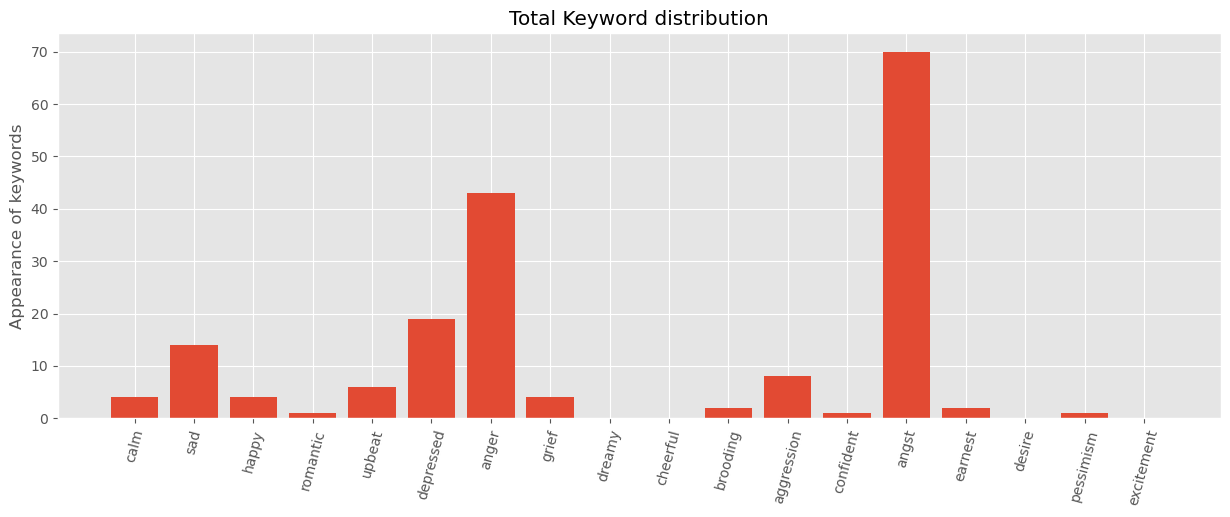

In [82]:
labels = [ k for k,v in keyword_distibution.items()]
data = [ v for k,v in keyword_distibution.items()]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)

ax.set_ylabel('Appearance of keywords')
plt.title('Total Keyword distribution')
plt.show()

# The figure shows how often the kexwords of a mood category appear in all english texts

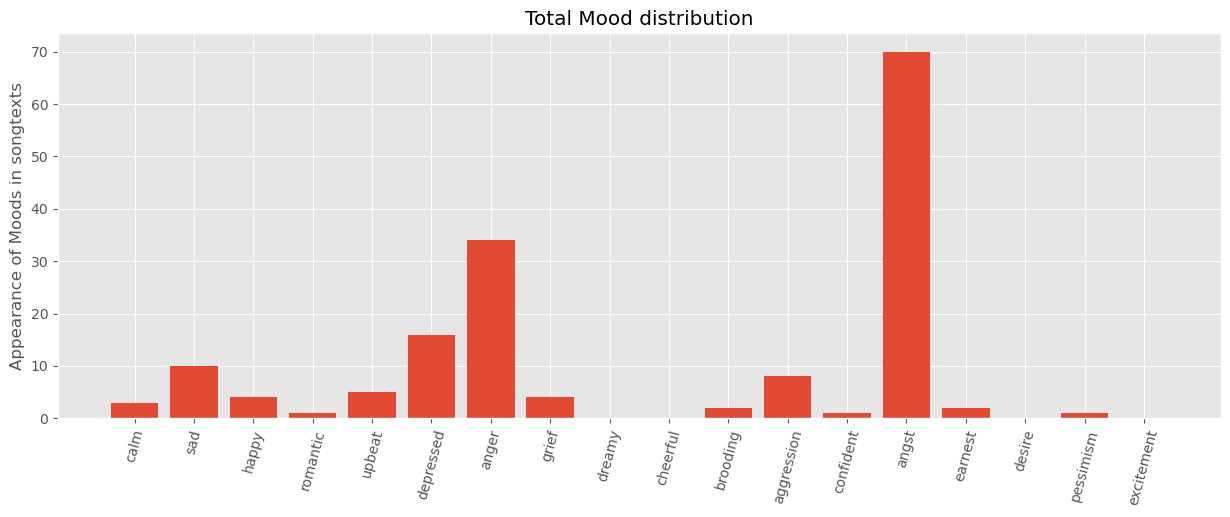

In [83]:
# The figure shows in how many songs the keywords of a mood category appear 
# (If for instance 2 keywords appear in 1 text, this counts as 1)",

labels = [ k for k,v in song_distribution.items()]
data = [ v for k,v in song_distribution.items()]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts')
plt.title('Total Mood distribution')
plt.show()

### Now plot the distribution with regards to the total ammount of songs

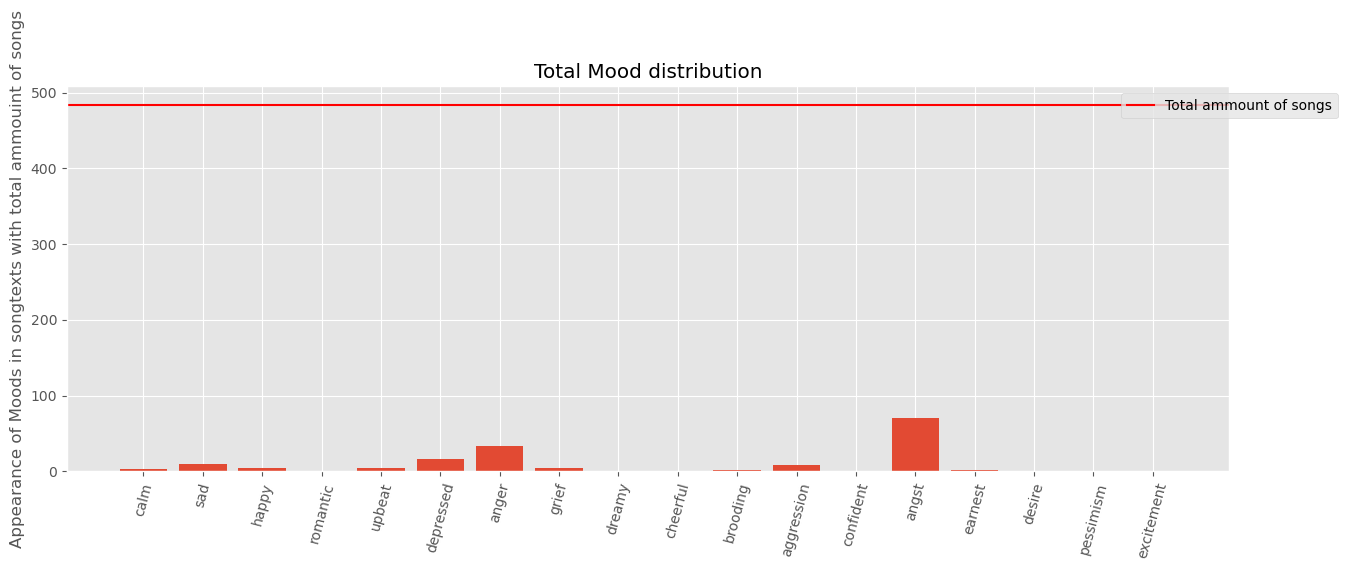

In [84]:
# The figure shows in how many songs the keywords of a mood category appear 
# (If for instance 2 keywords appear in 1 text, this counts as 1)",

labels = [ k for k,v in song_distribution.items()]
data = [ v for k,v in song_distribution.items()]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Appearance of Moods in songtexts with total ammouint of songs')
plt.title('Total Mood distribution')
plt.axhline(y = len(artists_songs_dataframe["Tags"]), color = 'r', linestyle = '-', label = "Total ammount of songs")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
plt.show()

## Now we will calculate how many songs can be identified with a mood at all

In [85]:
songs_without_moods = 0

for tag_list in artists_songs_dataframe["Tags"]:
    flag = 0
    for key in MOOD_CATEGORIES:
        for keyword in MOOD_CATEGORIES[key]:
            if keyword in tag_list:
                flag = 1
                break
    if flag == 0:
        songs_without_moods += 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


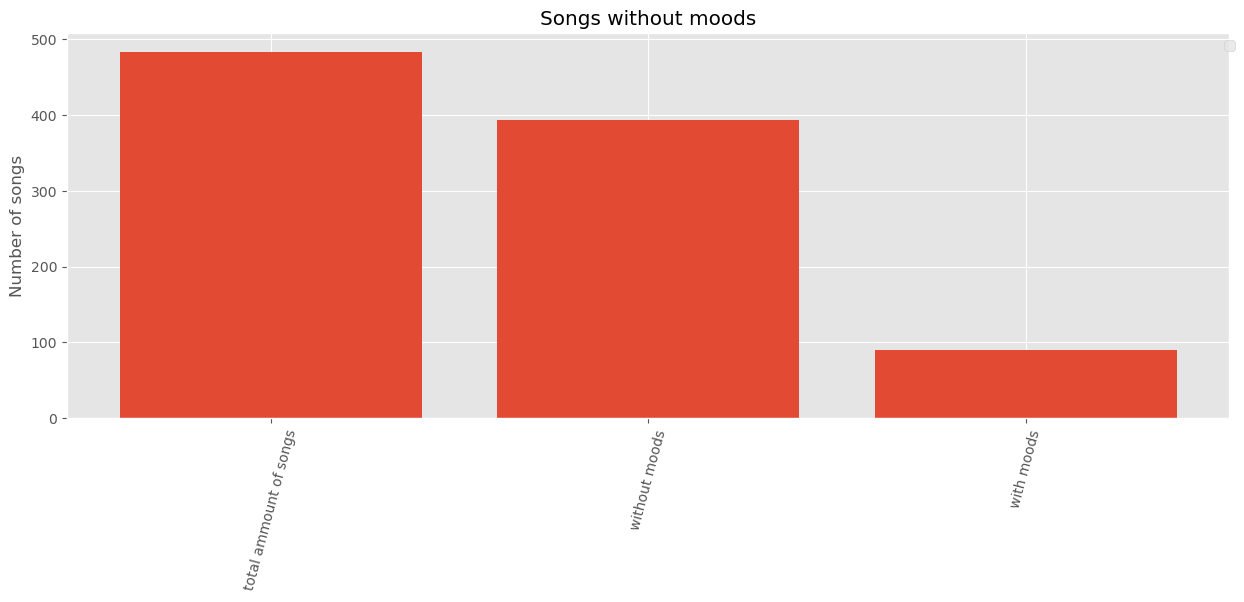

In [86]:
# the following figure shows the ammount of songs not containing any of the mood keywords

labels = ["total ammount of songs", "without moods", "with moods"]
data = [ len(artists_songs_dataframe["Tags"]), songs_without_moods, len(artists_songs_dataframe["Tags"])-songs_without_moods ]
fig, ax = plt.subplots()
plt.xticks(rotation = 75)
ax.bar(labels, data)
ax.set_ylabel('Number of songs')
plt.title('Songs without moods')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
plt.show()